https://www.tensorflow.org/text/tutorials/transformer

In [ ]:
!pip install -q tensorflow_datasets
!pip install -qU tensorflow-text

     |████████████████████████████████| 4.9 MB 5.5 MB/s 


In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_save_path = r'/content/drive/My Drive/data/'

Mounted at /content/drive


In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteZ4IMI5/ted_hrlr_translate-train.tfrecord


  0%|          | 0/208106 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteZ4IMI5/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/4805 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteZ4IMI5/ted_hrlr_translate-test.tfrecord


  0%|          | 0/5476 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [ ]:
model_name = "ted_hrlr_translate_ru_en_converter"
tokenizers = tf.saved_model.load(data_save_path + model_name)

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
    print(row)

[2, 41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16, 3]
[2, 84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16, 3]
[2, 10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16, 3]


In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
    print(line.decode('utf-8'))

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .
( video ) didi pickles : it ' s four o ' clock in the morning .


In [ ]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'c', b':', b'success', b',', b'the', b'change', b'is', b'only', b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun', b'.', b'[END]'], [b'[START]', b'the', b'document', b'##ation', b'and', b'the', b'hands', b'-', b'on', b'teaching', b'method', b'##ology', b'is', b'also', b'open', b'-', b'source', b'and', b'released', b'as', b'the', b'creative', b'commons', b'.', b'[END]'], [b'[START]', b'(', b'video', b')', b'did', b'##i', b'pick', b'##les', b':', b'it', b"'", b's', b'four', b'o', b"'", b'clock', b'in', b'the', b'morning', b'.', b'[END]']]>

In [ ]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    # Convert from ragged to dense, padding with zeros.
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return ru, en

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 128  # 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

(1, 2048, 512)


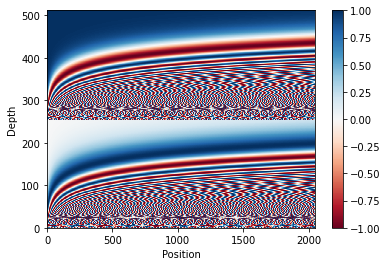

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, re_input, 
                 re_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, re_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, re_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)
        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)
        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    re_input=10000, re_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [ ]:
num_layers = 6  # 6
d_model = 128  # 512
dff = 512  # 2048
num_heads = 8
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

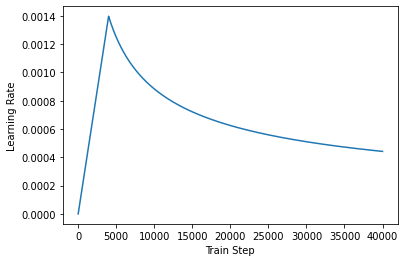

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
      mask = tf.math.logical_not(tf.math.equal(real, 0))
      loss_ = loss_object(real, pred)
      mask = tf.cast(mask, dtype=loss_.dtype)
      loss_ *= mask
      return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
      accuracies = tf.equal(real, tf.argmax(pred, axis=2))
      mask = tf.math.logical_not(tf.math.equal(real, 0))
      accuracies = tf.math.logical_and(mask, accuracies)
      accuracies = tf.cast(accuracies, dtype=tf.float32)
      mask = tf.cast(mask, dtype=tf.float32)
      return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.ru.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    re_input=1000,
    re_target=1000,
    rate=dropout_rate)

In [ ]:
checkpoint_path = f"{data_save_path}checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
      ckpt.restore(ckpt_manager.latest_checkpoint)
      print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp], training = True)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
# OPTIONAL
#gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    # inp -> russian, tar -> english
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    if (epoch + 1) % 2 == 0:  # 5
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 3.0975 Accuracy 0.4091
Epoch 1 Batch 50 Loss 3.0811 Accuracy 0.4016
Epoch 1 Batch 100 Loss 3.0728 Accuracy 0.4027
Epoch 1 Batch 150 Loss 3.0744 Accuracy 0.4025
Epoch 1 Batch 200 Loss 3.0736 Accuracy 0.4028
Epoch 1 Batch 250 Loss 3.0744 Accuracy 0.4026
Epoch 1 Batch 300 Loss 3.0771 Accuracy 0.4021
Epoch 1 Batch 350 Loss 3.0749 Accuracy 0.4027
Epoch 1 Batch 400 Loss 3.0737 Accuracy 0.4029
Epoch 1 Batch 450 Loss 3.0734 Accuracy 0.4029
Epoch 1 Batch 500 Loss 3.0737 Accuracy 0.4030
Epoch 1 Batch 550 Loss 3.0728 Accuracy 0.4031
Epoch 1 Batch 600 Loss 3.0718 Accuracy 0.4033
Epoch 1 Batch 650 Loss 3.0707 Accuracy 0.4034
Epoch 1 Batch 700 Loss 3.0705 Accuracy 0.4034
Epoch 1 Batch 750 Loss 3.0701 Accuracy 0.4034
Epoch 1 Batch 800 Loss 3.0687 Accuracy 0.4037
Epoch 1 Batch 850 Loss 3.0704 Accuracy 0.4034
Epoch 1 Batch 900 Loss 3.0706 Accuracy 0.4034
Epoch 1 Batch 950 Loss 3.0701 Accuracy 0.4036
Epoch 1 Batch 1000 Loss 3.0695 Accuracy 0.4037
Epoch 1 Batch 1050 Loss 3.0690 Accur

KeyboardInterrupt: ignored

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=20):
        # input sentence is russian, hence adding the start and end token
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
        sentence = self.tokenizers.ru.tokenize(sentence).to_tensor()
        encoder_input = sentence
        # as the target is english, the first token to the transformer should be the
        # english start token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]
        # `tf.TensorArray` is required here (instead of a python list) so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)
            # select the last token from the seq_len dimension
            predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
            predicted_id = tf.argmax(predictions, axis=-1)
            # concatentate the predicted_id to the output which is given to the decoder
            # as its input.
            output_array = output_array.write(i+1, predicted_id[0])
            if predicted_id == end:
                break
        output = tf.transpose(output_array.stack())
        # output.shape (1, tokens)
        text = tokenizers.en.detokenize(output)[0]  # shape: ()
        tokens = tokenizers.en.lookup(output)[0]
        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop. So recalculate them outside
        # the loop.
        _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)
        return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "Это проблема, которую нам необходимо решить."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Это проблема, которую нам необходимо решить.
Prediction     : this is the problem we need to solve .
Ground truth   : this is a problem we have to solve .


In [ ]:
sentence = "и мои соседи слышали об этой идее."
ground_truth = "and my neighbors heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : и мои соседи слышали об этой идее.
Prediction     : and i heard this talk about the world .
Ground truth   : and my neighbors heard about this idea .


In [ ]:
sentence = "данный законопроект предусматривает введение ответственности за совершение такого проступка."
ground_truth = "this bill provides for the introduction of liability for such a misconduct ."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : данный законопроект предусматривает введение ответственности за совершение такого проступка.
Prediction     : this is the state of the law that makes the decision to make the right thing .
Ground truth   : this bill provides for the introduction of liability for such a misconduct .


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The plot is of the attention when a token was generated.
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]
    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)
    plt.show()

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([18, 26])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.ru.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(26,), dtype=string, numpy=
array([b'[START]', b'\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xbd\xd1\x8b\xd0\xb8',
       b'\xd0\xb7\xd0\xb0\xd0\xba\xd0\xbe\xd0\xbd', b'##\xd0\xbe\xd0\xbf',
       b'##\xd1\x80\xd0\xbe\xd0\xb5', b'##\xd0\xba\xd1\x82', b'\xd0\xbf',
       b'##\xd1\x80\xd0\xb5\xd0\xb4', b'##\xd1\x83\xd1\x81',
       b'##\xd0\xbc\xd0\xb0', b'##\xd1\x82\xd1\x80',
       b'##\xd0\xb8\xd0\xb2\xd0\xb0\xd0\xb5\xd1\x82', b'\xd0\xb2',
       b'##\xd0\xb2\xd0\xb5\xd0\xb4\xd0\xb5\xd0\xbd\xd0\xb8\xd0\xb5',
       b'\xd0\xbe\xd1\x82\xd0\xb2\xd0\xb5\xd1\x82\xd1\x81\xd1\x82\xd0\xb2\xd0\xb5\xd0\xbd\xd0\xbd\xd0\xbe\xd1\x81\xd1\x82\xd0\xb8',
       b'\xd0\xb7\xd0\xb0', b'\xd1\x81\xd0\xbe',
       b'##\xd0\xb2\xd0\xb5\xd1\x80',
       b'##\xd1\x88\xd0\xb5\xd0\xbd\xd0\xb8\xd0\xb5',
       b'\xd1\x82\xd0\xb0\xd0\xba\xd0\xbe\xd0\xb3\xd0\xbe',
       b'\xd0\xbf\xd1\x80\xd0\xbe', b'##\xd1\x81\xd1\x82',
       b'##\xd1\x83\xd0\xbf', b'##\xd0\xba\xd0\xb0', b'.', b'[END]'],
      dtype=object)>

In [ ]:
translated_tokens

<tf.Tensor: shape=(19,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'state', b'of', b'the',
       b'law', b'that', b'makes', b'the', b'decision', b'to', b'make',
       b'the', b'right', b'thing', b'.', b'[END]'], dtype=object)>

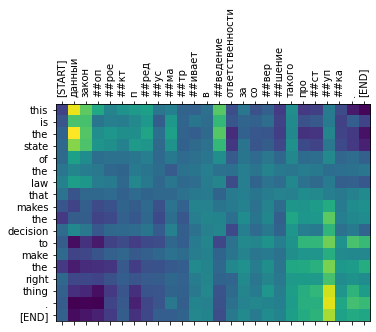

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.ru.lookup(in_tokens)[0]
    in_tokens
    fig = plt.figure(figsize=(16, 8))
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')
    plt.tight_layout()
    plt.show()

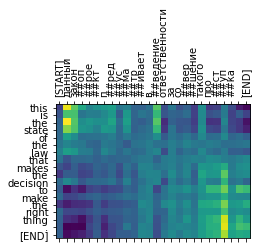

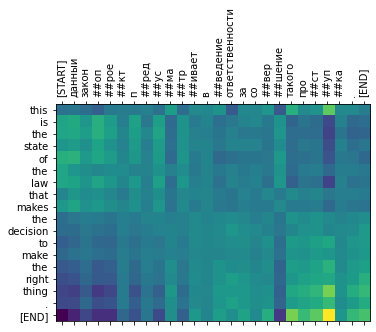

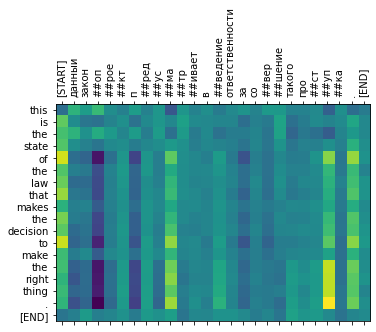

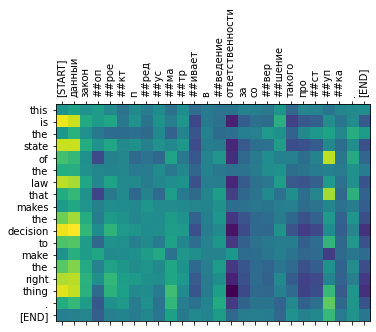

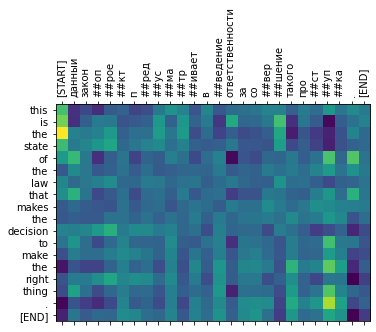

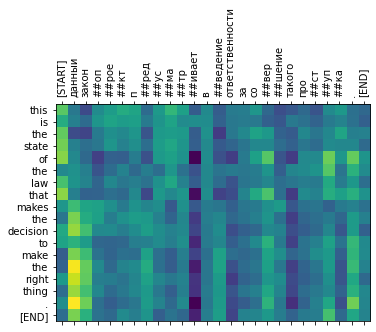

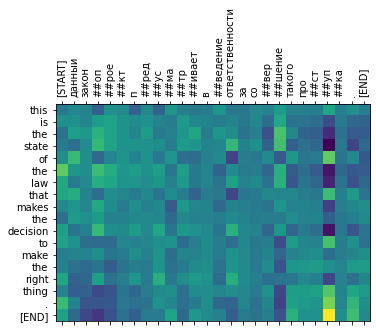

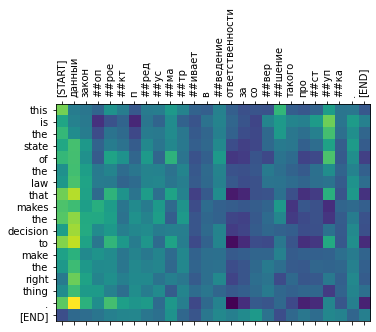

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result, tokens, attention_weights) = self.translator(sentence, max_length=100)
        return result

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
tf.saved_model.save(translator, export_dir=data_save_path + 'translator')

In [ ]:
reloaded = tf.saved_model.load(data_save_path + 'translator')
reloaded("Добро пожаловать в новый словарь.").numpy()

b'welcome to the new word .'